In [1]:
from sklearn import datasets
import numpy as np
from Model import Model
from Utils import split_pd, split_np

In [2]:
iris = datasets.load_iris(as_frame=True)

In [3]:
train_x, train_y, val_x, val_y = split_pd(iris['data'], iris['target'], 0.2)

In [4]:
k = lambda r: 1 / (r + 1)
d = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, -1))

In [5]:
train_x_np = train_x.to_numpy()
train_y_np = train_y.to_numpy()
hs = [0.1, 0.25, 0.5, 1.0, 1.5]
models = np.empty(len(hs), dtype=object)
for (i, h) in enumerate(hs):
    models[i] = Model(k, d, h)
    models[i].fit(train_x_np, train_y_np, 3)

In [6]:
for model in models:
    print(np.sum(model.predict(val_x.to_numpy()) == val_y.to_numpy()) / val_y.size)

0.9666666666666667
0.9666666666666667
0.9333333333333333
0.9333333333333333
0.9333333333333333


In [7]:
import pandas as pd
import seaborn as sns

In [8]:
train = train_x.copy()
train['col'] = train_y
preds = model.predict(val_x.to_numpy())
val = val_x.copy()
val['col'] = 3 + val_y * 3 + preds * 9
res = pd.concat((train, val))

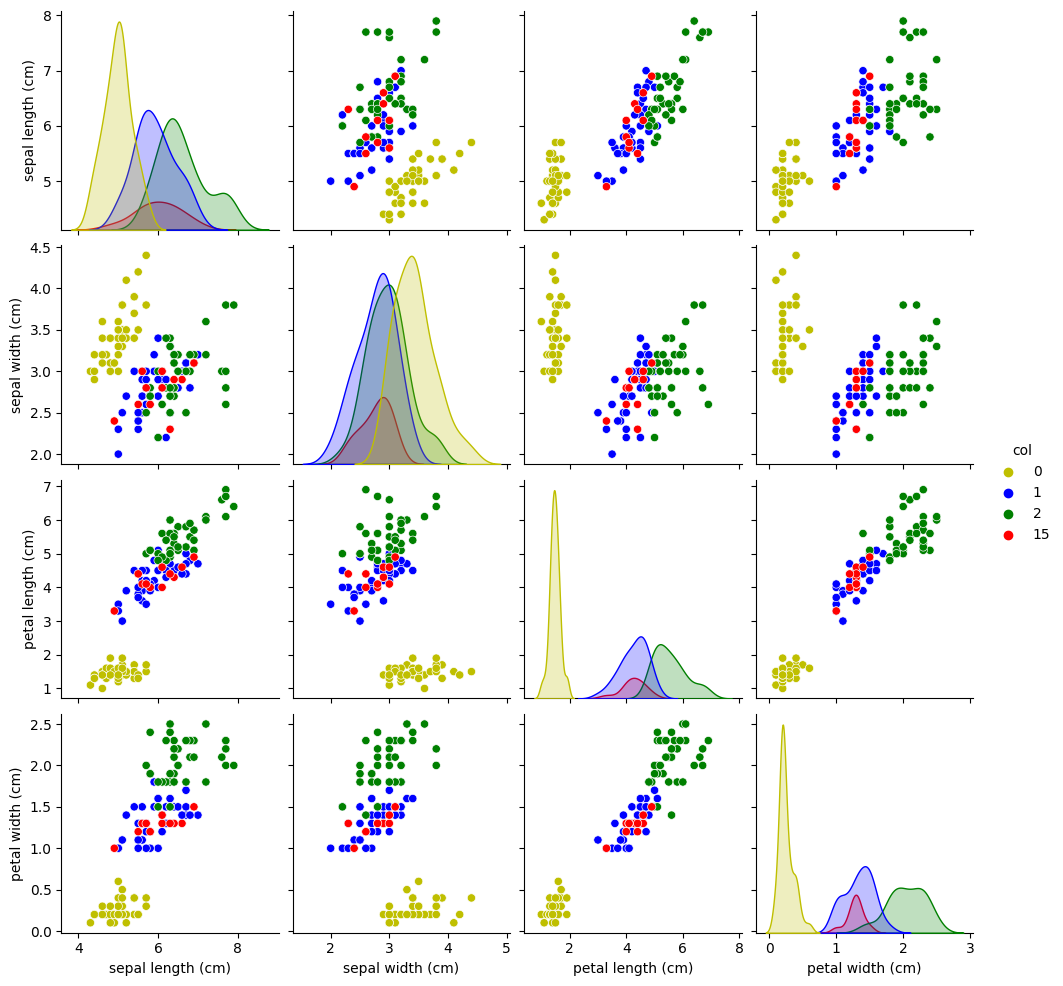

In [9]:
gt = 1
y = 1

sns.pairplot(res[(res['col'] == 3 + gt * 3 + y * 9) | (res['col'] < 3)], hue='col', palette={0: 'y', 1: 'b', 2: 'g', 3 + gt * 3 + y * 9: 'r'})